## Example 1 – One state variable
### Time-Varying Consumption Drift – Zero-Coupon Bond
The state variable is associated with the consumption drift. Given a CRRA utility function the SDF process can be computed, inserted in the pricing equation and then solved using a Feynman-Kac formula. The modified state variable follows the process:

$$
\mathrm{d}\hat{x}_t=\big(-\log\phi(\bar{x}-\hat{x}_t) +\rho_{cx}\sigma_c\sigma_x\big)\mathrm{d}t+\sigma_{x}\mathrm{d}W_{xt}
$$

While the state variable is not modified when there is no correlation between the process for consumption and the process for the state variable:

$$
\mathrm{d}x_t=-\log\phi(\bar{x}-x_t)\mathrm{d}t+\sigma_{x}\mathrm{d}W_{xt}
$$

In order to get the price of the zero-coupon security a process for the integral of the short-term rate will also be needed:

$$
\mathrm{d}\mathcal{I} = r(\bar{x}_t)\mathrm{d}t
$$

##### Import the packages

In [1]:
import SDFPricing as sdf
import StochasticDiffEq as sde # this is needed in order to specify the algorithm

#### Define the parameters

In [2]:
cs = (
    phi = 0.92, # mean reversion
    xbar = 0.0, # long-run mean
    rho = 0.01, # time preference parameter
    gamma = 2, # risk aversion
    muc0 = 0.005, # mean of consumption drift
    sigmac = 0.01, # consumption diffusion
    sigmax = 0.005, # state variable diffusion
    rhocx = 0.3 # correlation between consumption and state variable
);

#### Drift and Diffusion of the processes
I also include the unmodified process which will correspond to "risk-neutral pricing". By comparing normal pricing with risk-neutral pricing it is possible to compute excess returns.

In [3]:
mu0(x,c) = -log(c.phi)*(c.xbar-x) # drift of unmodified state
sigma(x,c) = c.sigmax; # diffusion of both modified and unmodified state
mu(x,c) = mu0(x,c)-c.rhocx*c.gamma*c.sigmac*sigma(x,c) # drift of modified state


mu (generic function with 1 method)

#### Short-term rate function

In [4]:
r(x,c) = c.rho+c.gamma*(c.muc0+x)-c.gamma^2*c.sigmac^2/2;
r(x) = r(x,cs); # define with one argument for convenience

#### Define setup consistent with SDE package in Julia

In [5]:
function drift(du,u,p,t,c)
    du[1] = mu0(u[1],c)
    du[2] = mu(u[2],c)
    du[3] = r(u[1],c)
    du[4] = r(u[2],c)
end
drift(du,u,p,t) = drift(du,u,p,t,cs);
function diffusion(du,u,p,t,c)
    du[1] = sigma(u[1],c)
    du[2] = sigma(u[2],c)
    du[3] = 0.0
    du[4] = 0.0
end
diffusion(du,u,p,t) = diffusion(du,u,p,t,cs);

#### Define the Problem and SolutionSettings variables

In [6]:
prob = sdf.Problem(drift=drift,diffusion=diffusion,numNoiseVariables=1,outVariables=[3,4],
terminalFunction=(ik, x, y, z) -> exp(-x));
xRange = -0.05:0.01:0.05;
sett = sdf.SolutionSettings(xRanges=[xRange,], initialValues=[[x, x, 0.0, 0.0] for x in xRange], 
algorithm=sde.LambaEM(), pathsPerInitialValue=10000, tRange=0.0:1.0:10.0);


#### Solve Problem and Define Yield

In [7]:
((bondPriceRiskNeutral,bondPrice),) = sdf.solve(prob, sett);
yld(t,x) = -log(bondPrice(t,x))/t;
yldRiskNeutral(t,x) = -log(bondPriceRiskNeutral(t,x))/t;

#### Plot the yield

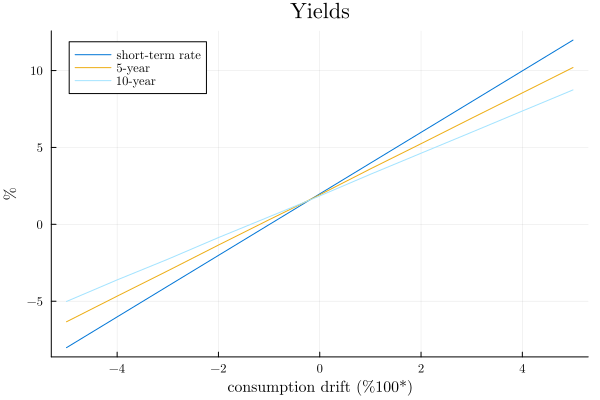

In [8]:
# colors: "#0075d6", "#edad14", "#a3e3ff", "#9c0000"
import Plots as plt
plt.default(titlefont= (14,"Computer Modern"),legendfont=(8,"Computer Modern"),
    tickfont=(8,"Computer Modern"),guidefont=(10,"Computer Modern"))
plt.plot(100*xRange, xRange .|> x->100*r(x), title="Yields",
    xlabel="consumption drift (%100*)",label="short-term rate",color="#0075d6",ylabel="%")
plt.plot!(100*xRange, 100*yld.(5.0, xRange), label="5-year",color= "#edad14")
plt.plot!(100*xRange, 100*yld.(10.0, xRange), label="10-year",color="#a3e3ff")

#### Plot the term premium

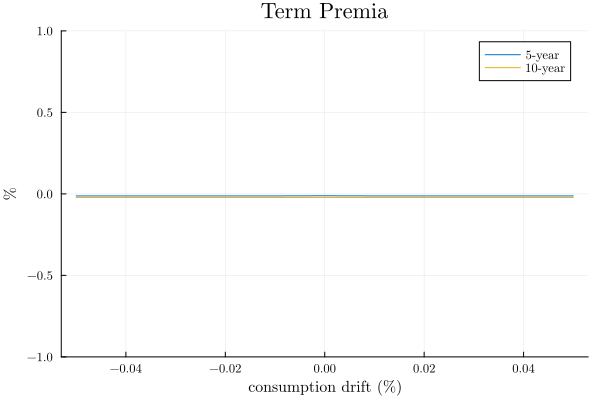

In [9]:
plt.plot(xRange, 100*(yld.(5.0, xRange) .- yldRiskNeutral.(5.0, xRange)),title="Term Premia",
    xlabel="consumption drift (%)",label="5-year",ylims=(-0.005,0.005),color="#0075d6",ylabel="%")
plt.plot!(xRange, 100*(yld.(10.0, xRange) .- yldRiskNeutral.(10.0, xRange)),
    label="10-year",ylims=(-1,1),color="#edad14")

This shows that term premia in such a model with a time-varying consumption drift are negative, very small, and constant. 